# Predict gene knockout strategies

In cameo we have two ways of predicting gene knockout targets: using evolutionary algorithms (OptGene) or linear programming (OptKnock)

<div class="alert alert-warning">
If you're running this notebook on [try.cameo.bio](http://try.cameo.bio), things might run very slow due to our inability to provide access to the proprietary [CPLEX](https://www-01.ibm.com/software/commerce/optimization/cplex-optimizer/) solver on a public webserver. Furthermore, Jupyter kernels might crash and restart due to memory limitations on the server.
</div>

In [1]:
from cameo import models
from cameo.visualization.plotting.with_plotly import PlotlyPlotter

In [2]:
model = models.bigg.iJO1366
plotter = PlotlyPlotter()

In [3]:
wt_solution = model.optimize()
growth = wt_solution.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"]
acetate_production = wt_solution.fluxes["EX_ac_e"]

In [4]:
from cameo import phenotypic_phase_plane

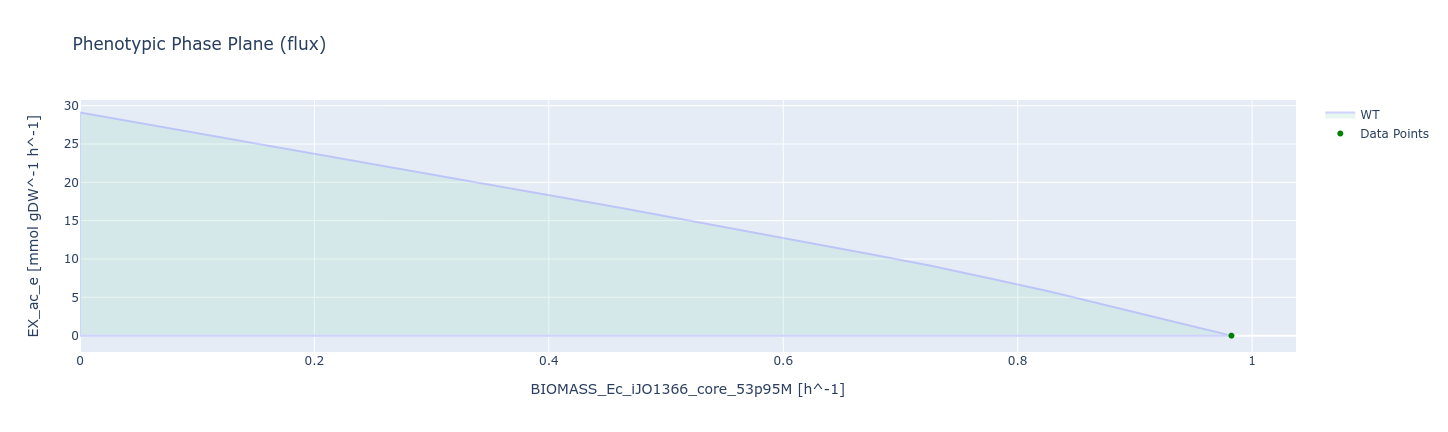

In [5]:
p = phenotypic_phase_plane(model, variables=['BIOMASS_Ec_iJO1366_core_53p95M'], objective='EX_ac_e')
p.plot(plotter, points=[(growth, acetate_production)])

## OptGene

OptGene is an approach to search for gene or reaction knockouts that relies on evolutionary algorithms[1]. The following image from the authors summarizes OptGene workflow.

<img src="http://static-content.springer.com/image/art%3A10.1186%2F1471-2105-6-308/MediaObjects/12859_2005_Article_632_Fig1_HTML.jpg"/>

At every iteration, we keep the best 50 individuals found overall so we can generate a library of targets.

In [6]:
from cameo.strain_design import OptGene

In [7]:
optgene = OptGene(model)

In [8]:
result = optgene.run(target=model.reactions.EX_ac_e, 
                     biomass=model.reactions.BIOMASS_Ec_iJO1366_core_53p95M,
                     substrate=model.metabolites.glc__D_e,
                     max_evaluations=5000,
                     plot=False)

Starting optimization at Mon, 01 Mar 2021 16:38:37


HBox()

Finished after 00:45:58


In [9]:
result

HBox()

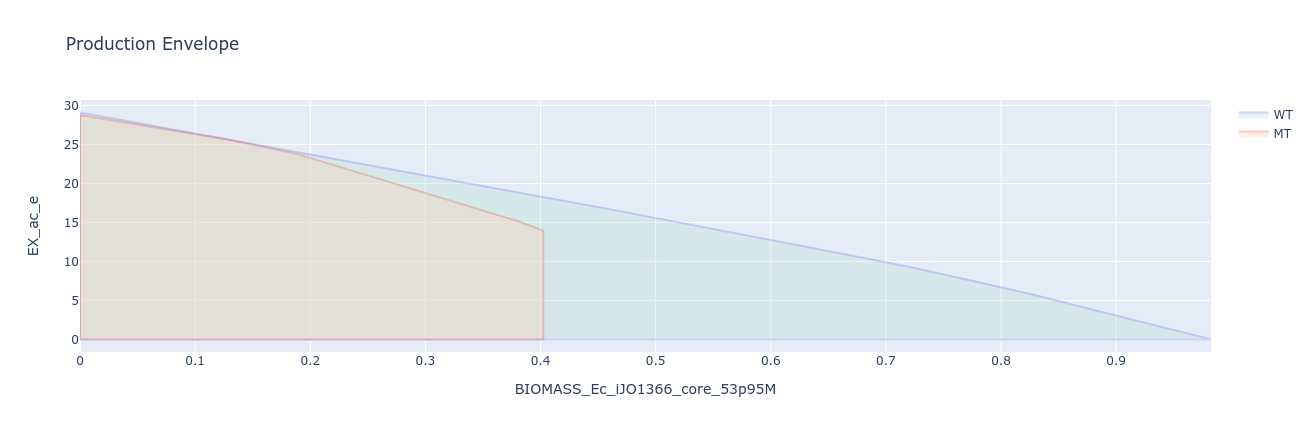

In [10]:
result.plot(plotter, 0)

In [11]:
result.display_on_map(0, "iJO1366.Central metabolism")

Builder(reaction_data={'EX_co2_e': 15.638742, 'EX_cobalt2_e': -1e-05, 'DM_4crsol_c': 9e-05, 'DM_5drib_c': 9e-0…

## OptKnock

OptKnock uses a bi-level mixed integer linear programming approach to identify reaction knockouts[2]:

$$
\begin{matrix}
maximize & \mathit{v_{chemical}} & & (\mathbf{OptKnock}) \\
\mathit{y_j} & & & \\
subject~to & maximize & \mathit{v_{biomass}} & (\mathbf{Primal}) \\
& \mathit{v_j} & & & & \\
\end{matrix}\\
\begin{bmatrix}
subject~to  & \sum_{j=1}^{M}S_{ij}v_{j} = 0,\\ 
& v_{carbon\_uptake} = v_{carbon~target}\\ 
& v_{apt} \ge v_{apt\_main}\\ 
& v_{biomass} \ge v_{target\_biomass}\\ 
& v_{j}^{min} \cdot y_j \le v_j \le v_{j}^{max} \cdot y_j, \forall j \in \boldsymbol{M} \\
\end{bmatrix}\\
\begin{align}
 & y_j = {0, 1}, & & \forall j \in \boldsymbol{M} & \\
 & \sum_{j \in M} (1 - y_j) \le K& & & \\
\end{align}
$$



In [12]:
from cameo.strain_design import OptKnock

In [13]:
optknock = OptKnock(model, fraction_of_optimum=0.1)

Running multiple knockouts with OptKnock can take a few hours or days...


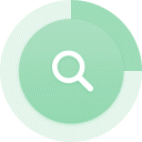

<IPython.core.display.Javascript object>

In [14]:
result = optknock.run(max_knockouts=1, target="EX_ac_e", biomass="BIOMASS_Ec_iJO1366_core_53p95M")

In [15]:
result

HBox()

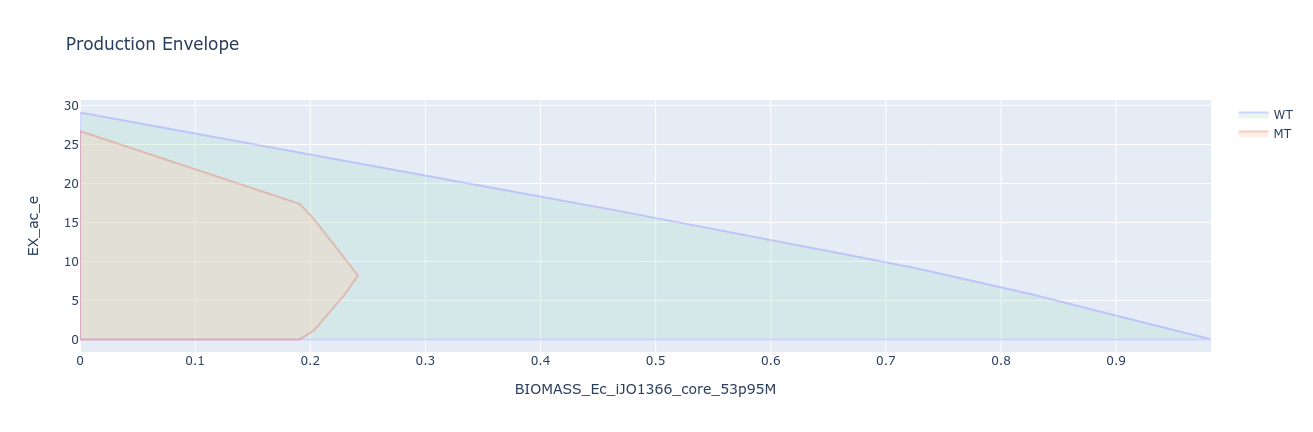

In [16]:
result.plot(plotter, 0)

In [17]:
result.display_on_map(0, "iJO1366.Central metabolism")

Builder(reaction_data={'EX_co2_e': -0.088228, 'EX_cobalt2_e': -6e-06, 'DM_4crsol_c': 5.4e-05, 'DM_5drib_c': 0.…

## References

[1]Patil, K. R., Rocha, I., Förster, J., & Nielsen, J. (2005). Evolutionary programming as a platform for in silico metabolic engineering. BMC Bioinformatics, 6, 308. doi:10.1186/1471-2105-6-308

[2]Burgard, A.P., Pharkya, P., Maranas, C.D. (2003), "OptKnock: A Bilevel Programming Framework for Identifying Gene Knockout Strategies for Microbial Strain Optimization," Biotechnology and Bioengineering, 84(6), 647-657.